# Section notes: Linear regression (scratch)
Notes by Jacob Quinn Shenker (10/30/2020). These notes were heavily inspired by [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686), which I cannot recommend highly enough. See also a [pymc3 implementation](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html) of the outlier-detection mixture model described in that paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import logsumexp
%config InlineBackend.figure_format = 'retina'

In [2]:
X_LABEL = "Concentration (ng/uL)"
Y_LABEL = "A260"

## Setting up the problem

**Below is the code used to generate your absorbance data. Feel free to read it to understand how these synthetic data are generated, but otherwise you can skip it.**

In [3]:
def generate_random_data(num_points, num_replicates, m=1/50, b=0, x_min=5, x_max=800,
                         mistake_probabilities=(0.8, 0.0, 0.2),
                         multiplicative_error=0, additive_error=1):
    # an array of with values 0/1/2
    # 0: normal measurement
    # 1: erroneous measurement (uniformly random)
    # 2: sample is empty
    measurement_type = np.random.choice(3, p=mistake_probabilities, size=(num_points, num_replicates))
    # normal measurements
    xs = np.random.uniform(x_min, x_max, size=num_points)
    xs_with_replicates = np.repeat(xs[:,np.newaxis], num_replicates, axis=1)
    ys_normal_without_noise = m * xs + b
    ys_normal = (ys_normal_without_noise[:,np.newaxis]
                    * np.random.normal(1, multiplicative_error, size=(num_points, num_replicates))
                    + np.random.normal(0, additive_error, size=(num_points, num_replicates)))
    # erroneous measurements
    y_min, y_max = m * np.array([x_min, x_max]) + b
    ys_erroneous = np.random.uniform(y_min, y_max, size=(num_points, num_replicates))
    # add multiplicative and additive error terms in quadrature
    empty_error = np.sqrt((multiplicative_error * y_max)**2 + additive_error**2)
    # empty sample measurements
    ys_empty = np.random.normal(0, empty_error, size=(num_points, num_replicates))
    ys = ((measurement_type == 0) * ys_normal
                        + (measurement_type == 1) * ys_erroneous
                        + (measurement_type == 2) * ys_empty)
    # add multiplicative and additive error terms in quadrature
    sigma_ys = np.sqrt((multiplicative_error * ys)**2 + additive_error**2)
    return xs_with_replicates, ys, sigma_ys

def prepare_data(xs, ys, sigma_ys, average_replicates=True):
    if average_replicates:
        xs = np.mean(xs, axis=1)
        sigma_ys = stats.sem(ys, axis=1)
        ys = np.mean(ys, axis=1)
    else:
        # include each replicate as a separate observation
        xs = xs.reshape(-1)
        ys = ys.reshape(-1)
        sigma_ys = sigma_ys.reshape(-1)
    data_ary = np.array([xs, ys, sigma_ys]).T
    data_df = pd.DataFrame(data_ary, columns=["conc", "A260", "sigma_A260"])
    return data_df

## Generating the data

Every time you run `generate_random_data`, it generates new synthetic data (here, we generate 3 replicate measurements for each of 20 DNA concentrations). We then use `prepare_data` to turn the output of `generate_random_data` into a pandas DataFrame. Note that `prepare_data` takes an `average_replicates` flag. When `average_replicates=True`, we take all the replicates for a single DNA concentration and replace them with a single data point (whose mean is the sample mean of the replicates, and whose error bar is the standard error of the mean of the replicates). When `average_replicates=False`, we include each individual replicate as its own data point, and all data points are assigned equal error bars.

You can run `generate_random_data` once to randomly generate data, and re-run `prepare_data` as many times as you want for the same synthetic dataset to observe how `average_replicates` affects the results in the rest of this notebook.

Note that `generate_random_data` takes many arguments that allow you to change the amount of measurement error, range of the data, and assumed calibration factor.

In [4]:
np.random.seed(732) # comment this out to generate new random data!
data_replicates = generate_random_data(12, 3)

In [5]:
data_no_avg = prepare_data(*data_replicates, average_replicates=False)

In [6]:
data_avg = prepare_data(*data_replicates, average_replicates=True)

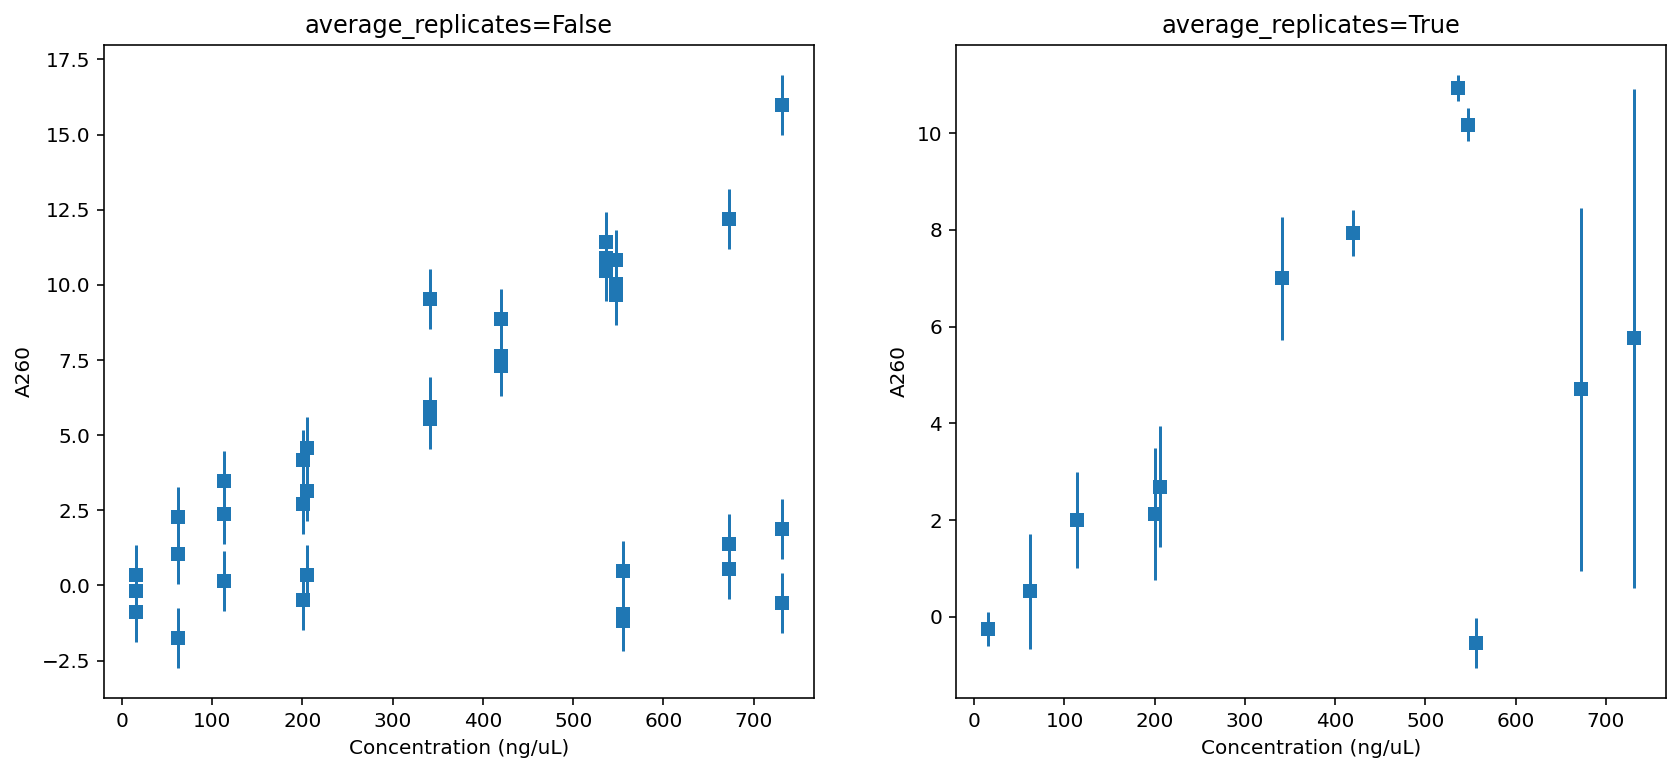

In [7]:
fig = plt.figure(figsize=(14,6))
plots = {"average_replicates=False": data_no_avg, "average_replicates=True": data_avg}
for plot_num, (title, d) in enumerate(plots.items()):
    ax = fig.add_subplot(1, 2, plot_num + 1)
    ax.errorbar(d["conc"], d["A260"], d["sigma_A260"], fmt="s")
    ax.set_title(title)
    plt.xlabel(X_LABEL)
    plt.ylabel(Y_LABEL);

For the remainder of this notebook, we're going to focus on `average_replicates=True`. After all, in your training as a scientist, you learned to do three replicates of every measurement and average the results! This is an extremely common procedure in science. Is it always the best thing to do? We will return to this issue later.

In [8]:
data = data_avg

## Four possible answers

Your colleagues email back, and each of them is convinced that they've correctly measured the calibration factor despite the noise in the data. Oh no, you think, they've all come up with different answers! Which is the “best” line? Which calibration factor should you use? Here are the plots each of them sent you:

In [9]:
lines = {"Sofía": (0.009, 1.09),
         "Li": (0.017, -0.25),
         "Fatma": (0.02, -0.59),
         "Nozomi": (0.013, 1.45)}

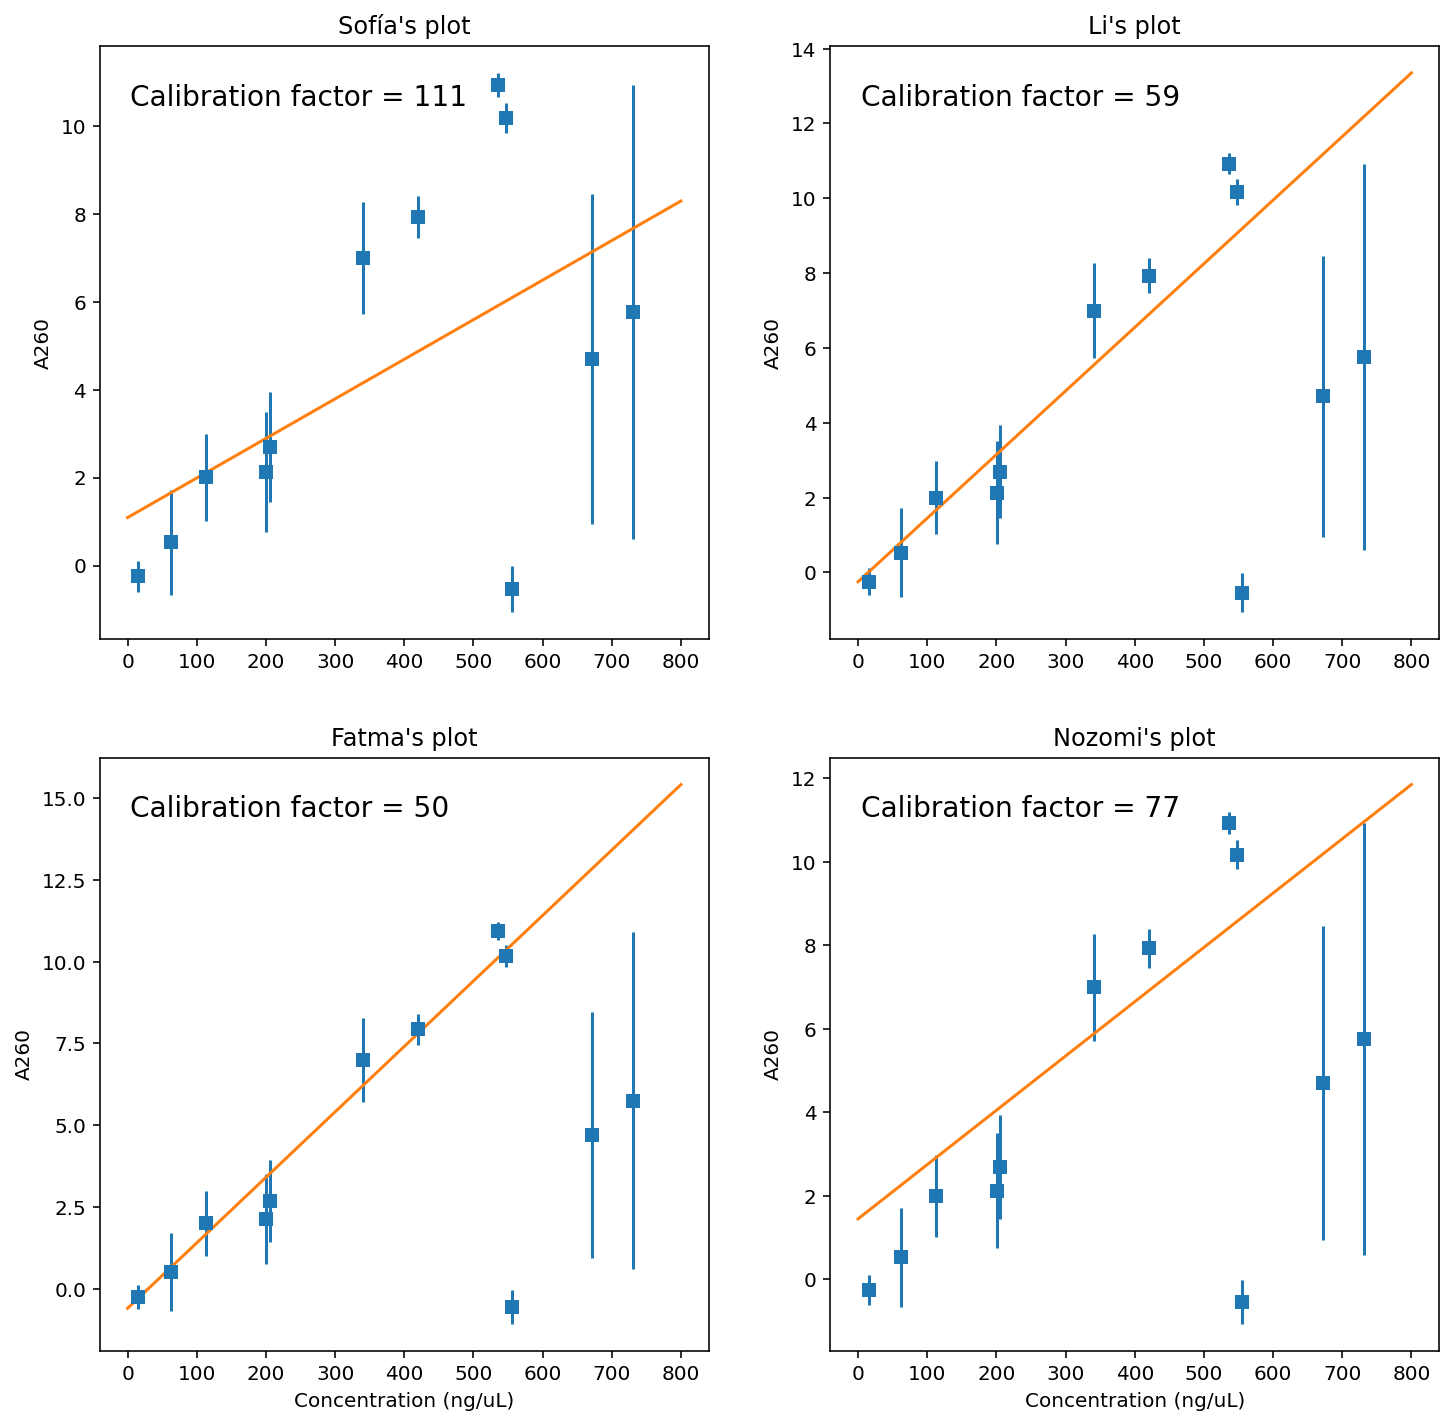

In [10]:
xs = np.linspace(0, 800, 10)
fig = plt.figure(figsize=(12,12))
for plot_num, (name, line) in enumerate(lines.items()):
    ax = fig.add_subplot(2, 2, plot_num + 1)
    ax.errorbar(data["conc"], data["A260"], data["sigma_A260"], fmt="s")
    ax.plot(xs, line[0] * xs + line[1])
    plt.text(0.05, 0.9, "Calibration factor = {:.0f}".format(1/line[0]), fontdict={"size": 14}, transform=ax.transAxes)
    ax.set_title(f"{name}'s plot")
    if plot_num >= 2: # only show x-axis label on bottom two plots, otherwise it overlaps with plot title
        plt.xlabel(X_LABEL)
    plt.ylabel(Y_LABEL);

## Least squares with maximum likelihood

Because $\log x$ is a monotonic function (it always goes up, never goes down, for increasing $x$ values), maximizing the log-likelihood is equivalent to maximizing the likelihood. As we've discussed numerous times, working with log-likelihoods is easier because you avoid problems with underflows. Scipy's optimizers minimize, so instead of maximizing the log-likelihood, we'll minimize the negative log-likelihood (“NLL”).

In [11]:
# here we define the negative log-likelihood
def nll_slow(params, xs, ys, sigmas):
    ll = 0
    # params is a numpy array of length two containing m and b
    m = params[0]
    b = params[1]
    # for each data point, add a term to the log-likelihood
    for i in range(len(xs)):
        y_pred = m * xs[i] + b
        residual = ys[i] - y_pred
        # this is equivalent to stats.norm.logpdf(ys[i], loc=y_pred, scale=sigmas[i])
        ll += stats.norm.logpdf(residual, loc=0, scale=sigmas[i])
    return -ll # return negative log-likelihood

We're actually going to rewrite this function to take advantage of numpy vectorization. Instead of looping over each data point individually, we can calculate each term of the log-likelihood all at once by passing in numpy arrays into stats.norm.logpdf, and getting back a numpy array of the same length containing logpdf values (we just need to sum them). Using vectorization often results in more readable code, and for large datasets will be much faster. If you like, you can check that `nll_slow` produces the same answer as `nll` given the same arguments.

In [12]:
def nll(params, xs, ys, sigmas):
    m, b = params
    y_pred = m * xs + b
    ll_terms = stats.norm.logpdf(ys - y_pred, loc=0, scale=sigmas)
    return -ll_terms.sum()

Now we use `scipy.optimize.minimize` to minimize our log-likelihood. We pass in the function to optimize, an initial guess for the parameter values (`m` and `b`), and a tuple (or list) of arguments to be passed to your function (in this case, the x data, y data, and y error bars). In simple problems, the initial guess often doesn't matter; it often does matter for more complex problems. (Can you think of how you might avoid problems here? Recall how you handled initial parameters in the k-means problem set!)

In [13]:
guess = np.array([0, 0]) # guess for m and b

sigma_y = 1 # assume equal errors for all points

minimization_ols = optimize.minimize(nll, guess, (data["conc"], data["A260"], sigma_y))
m = minimization_ols.x[0]
b = minimization_ols.x[1]
print(f"OLS with maximum likelihood: y = {m:.3f}x + {b:.2f}")
# calculate the y values predicted by our linear model
predicted_ols = m * data["conc"] + b

OLS with maximum likelihood: y = 0.009x + 1.09


In [14]:
guess = np.array([0, 0]) # guess for m and b

sigma_y = data["sigma_A260"] # use measurement errors given in data file

minimization_wls = optimize.minimize(nll, guess, (data["conc"], data["A260"], sigma_y))
m = minimization_wls.x[0]
b = minimization_wls.x[1]
print(f"WLS with maximum likelihood: y = {m:.3f}x + {b:.2f}")
# calculate the y values predicted by our linear model
predicted_wls = m * data["conc"] + b

WLS with maximum likelihood: y = 0.017x + -0.25


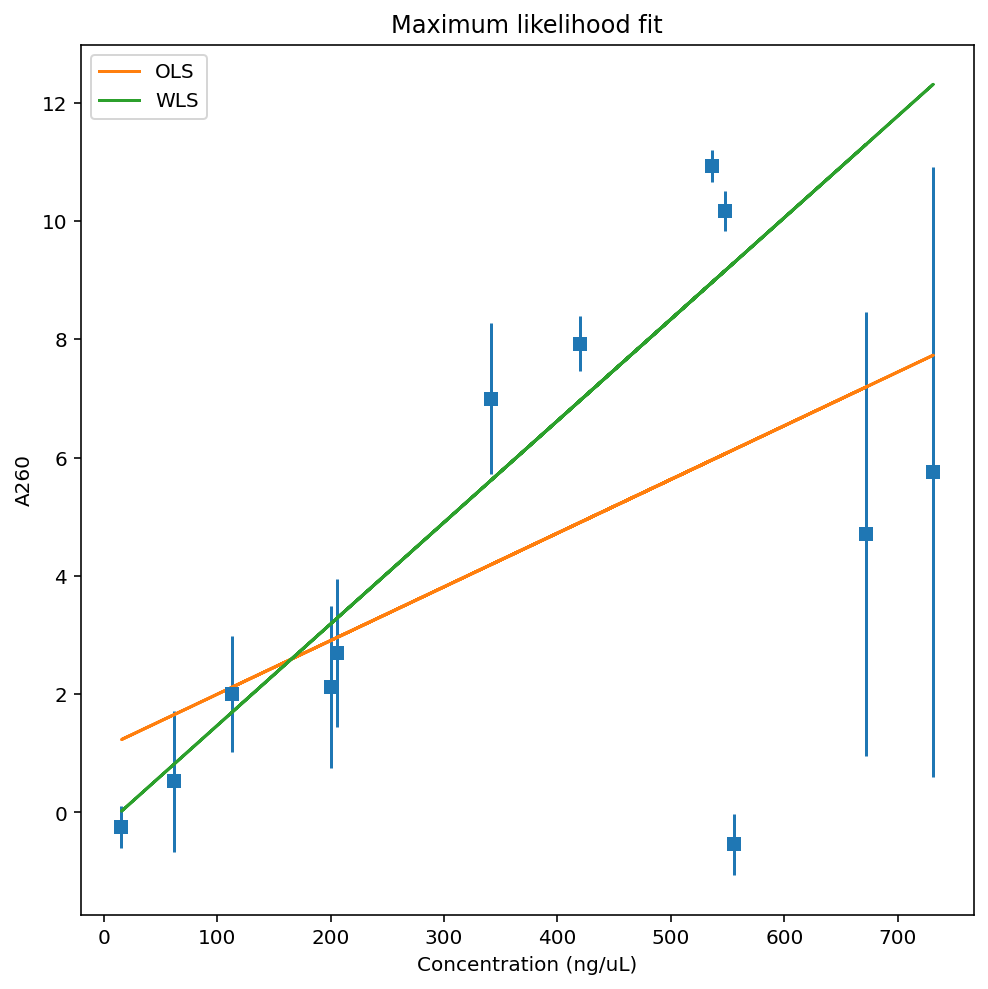

In [15]:
fig = plt.figure(figsize=(8,8))
plt.errorbar(data["conc"], data["A260"], data["sigma_A260"], fmt="s")
plt.plot(data["conc"], predicted_ols, label="OLS")
plt.plot(data["conc"], predicted_wls, label="WLS")
plt.title("Maximum likelihood fit")
plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL);

## Parameter uncertainties

In [252]:
ms = np.linspace(0.01, 0.03, 100)
bs = np.linspace(-1.5, 1.5, 100)
sigmas = data["sigma_A260"].values[np.newaxis,np.newaxis,:]
predictions = ms[:,np.newaxis,np.newaxis] * data["conc"].values[np.newaxis,np.newaxis,:] + bs[np.newaxis,:,np.newaxis]
residuals = predictions - data["A260"].values[np.newaxis,np.newaxis,:]
rss = residuals.sum(axis=-1)
ll_terms = stats.norm.logpdf(residuals, loc=0, scale=sigmas)
ll = ll_terms.sum(axis=-1)
m_prior = stats.norm.logpdf(ms, loc=0.02, scale=0.01)
b_prior = stats.norm.logpdf(bs, loc=0, scale=1)
log_posterior = ll + m_prior[:,np.newaxis] + b_prior[np.newaxis,:]
log_posterior -= logsumexp(log_posterior)
posterior = np.exp(log_posterior)
likelihood = np.exp(ll)

Here is the joint likelihood.

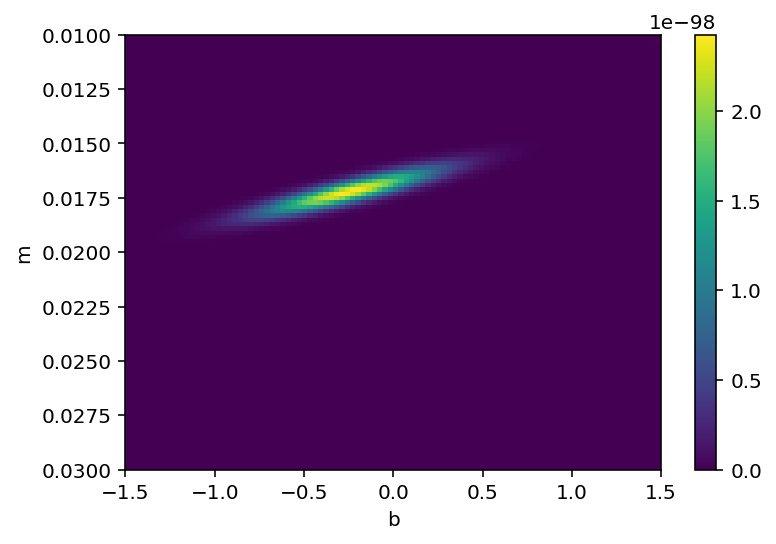

In [253]:
# extent=[left x-value, right x-value, top y-value, bottom y-value]
plt.imshow(likelihood, extent=[bs[0], bs[-1], ms[-1], ms[0]], aspect="auto")
plt.colorbar();
plt.xlabel("b")
plt.ylabel("m");

And here's the posterior, which is just the product of the likelihood and the prior probabilities of each of the parameters. Try adjusting the prior distributions to make them narrower, see if you can make the posterior look qualitatively different than the likelihood.

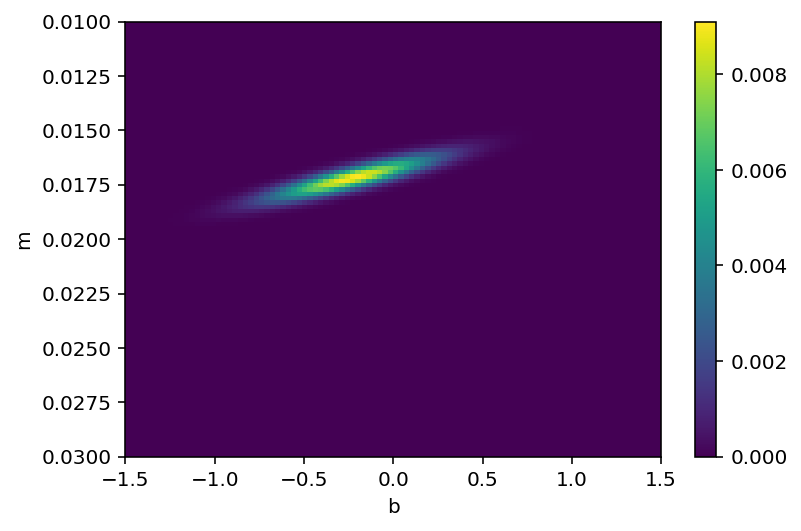

In [254]:
plt.imshow(posterior, extent=[bs[0], bs[-1], ms[-1], ms[0]], aspect="auto")
plt.colorbar();
plt.xlabel("b")
plt.ylabel("m");

We can also marginalize by summing our two-dimensional array of probabilities to get one-dimensional probabilities of each parameter separately.

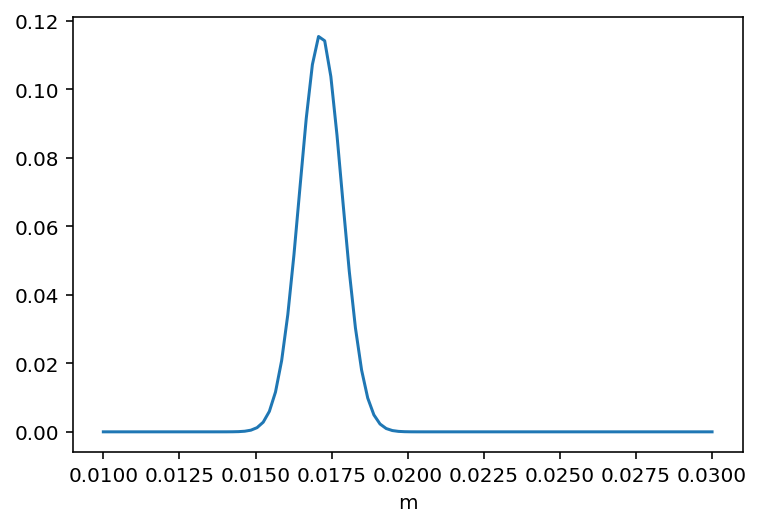

In [255]:
plt.plot(ms, posterior.sum(axis=1))
plt.xlabel("m");

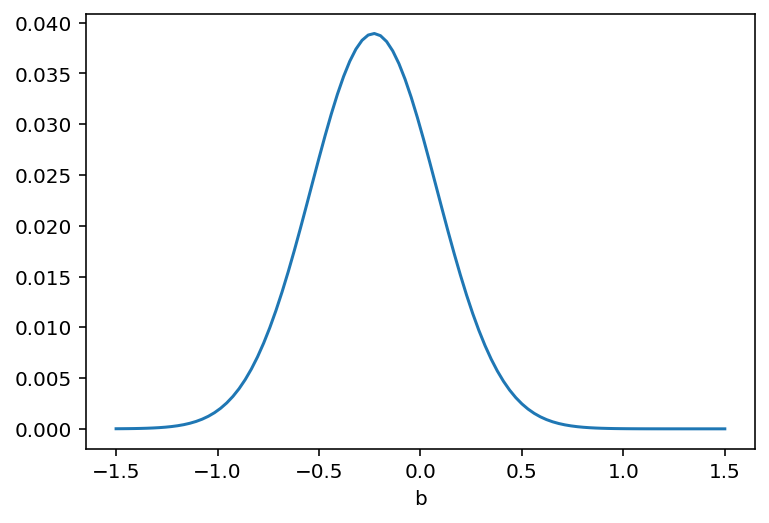

In [257]:
plt.plot(bs, posterior.sum(axis=0))
plt.xlabel("b");

## Prediction uncertainty

What happens if we make an A260 measurement and we want to know what our uncertainty in DNA concentration should be?

In [273]:
new_A260 = 11
new_predictions = (new_A260 - bs[np.newaxis,:,np.newaxis]) / ms[:,np.newaxis,np.newaxis]
new_predictions = new_predictions.reshape((-1,))
order = new_predictions.argsort()
sorted_predictions = new_predictions[order]
prediction_posterior = posterior.reshape((-1,))[order]

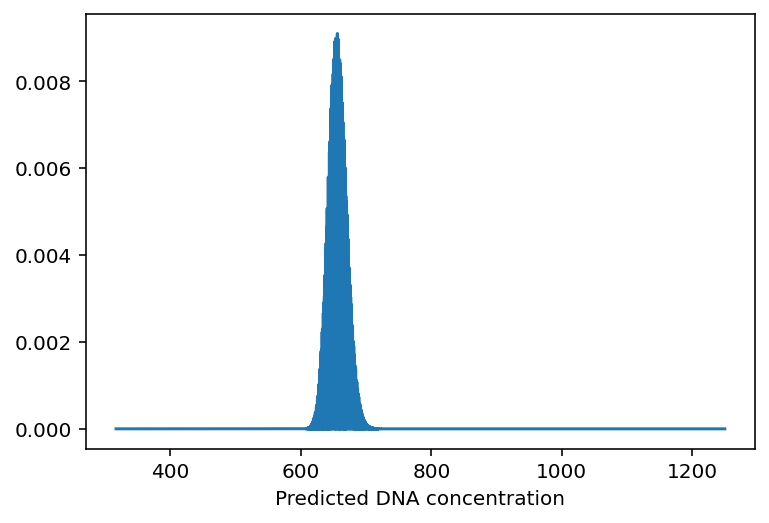

In [277]:
plt.plot(sorted_predictions, prediction_posterior)
plt.xlabel("Predicted DNA concentration");